<a href="https://colab.research.google.com/github/yohanesnuwara/petroleum-data-analytics-series/blob/main/03_OptimizationDrillingROP/ROP_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rate of Penetration Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns
plt.rcParams['font.size'] = 20

!pip -q install pyswarm
from pyswarm import pso

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
!git clone https://github.com/yohanesnuwara/petroleum-data-analytics-series

Cloning into 'petroleum-data-analytics-series'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [3]:
# Read from path to CSV file
path = '/content/petroleum-data-analytics-series/03_OptimizationDrillingROP/Data_for_ROP_optimization.csv'
df = pd.read_csv(path)

df.head()

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
0,3305.0,26217.864,1.314720,0.004088,0.086711,0.071719,1.0,0.001
1,3310.0,83492.293,1.328674,0.005159,0.095208,0.116548,1.0,0.001
2,3315.0,97087.882,1.420116,0.005971,0.061636,0.104283,1.0,0.001
3,3320.0,54793.206,1.593931,0.005419,0.043498,0.110040,1.0,0.001
4,3325.0,50301.579,1.653262,0.005435,0.035252,0.120808,1.0,0.001


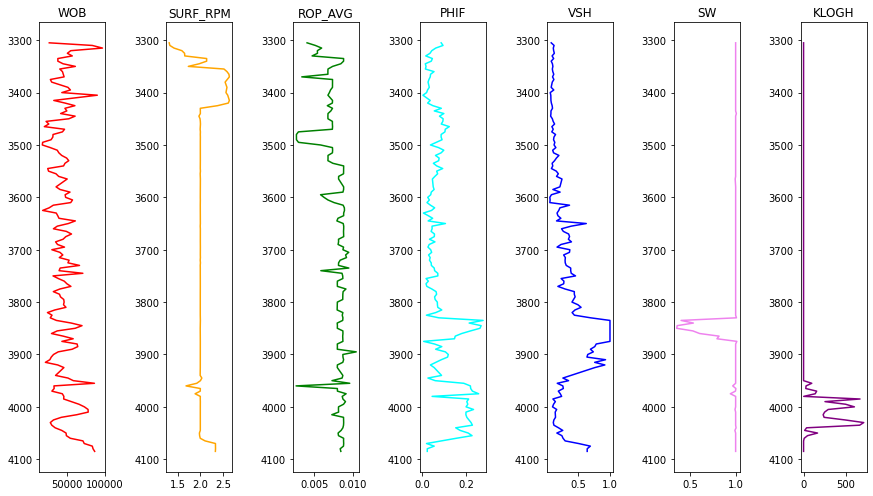

In [4]:
# Display logs
logs = df.columns[1:]
colors = ['red', 'orange', 'green', 'cyan', 'blue', 'violet', 'purple']

plt.figure(figsize=(14,7))
for i in range(len(logs)):
  plt.subplot(1,8,i+1)
  plt.plot(df[logs[i]], df.Depth, color=colors[i])
  plt.title(logs[i])
  plt.gca().invert_yaxis()

plt.tight_layout()

In [5]:
def corr_heatmap(df):
  # Generate a mask for the upper triangle
  mask = np.zeros_like(df.corr(method = 'spearman') , dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Generate a custom diverging colormap
  cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)
  cmap = 'PRGn'
  cmap = 'plasma'

  # Draw the heatmap with the mask and correct aspect ratio
  plt.figure(figsize=(12,10))
  sns.heatmap(df.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, 
              vmin=0, vmax=1, square=True)

  plt.show()

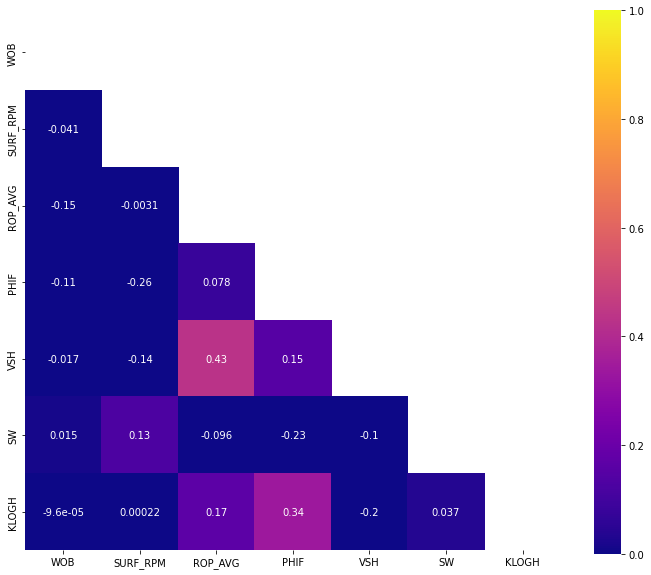

In [6]:
# All features without depth
no_depth = df.columns[1:]

# Plot correlation heatmap
corr_heatmap(df[no_depth])

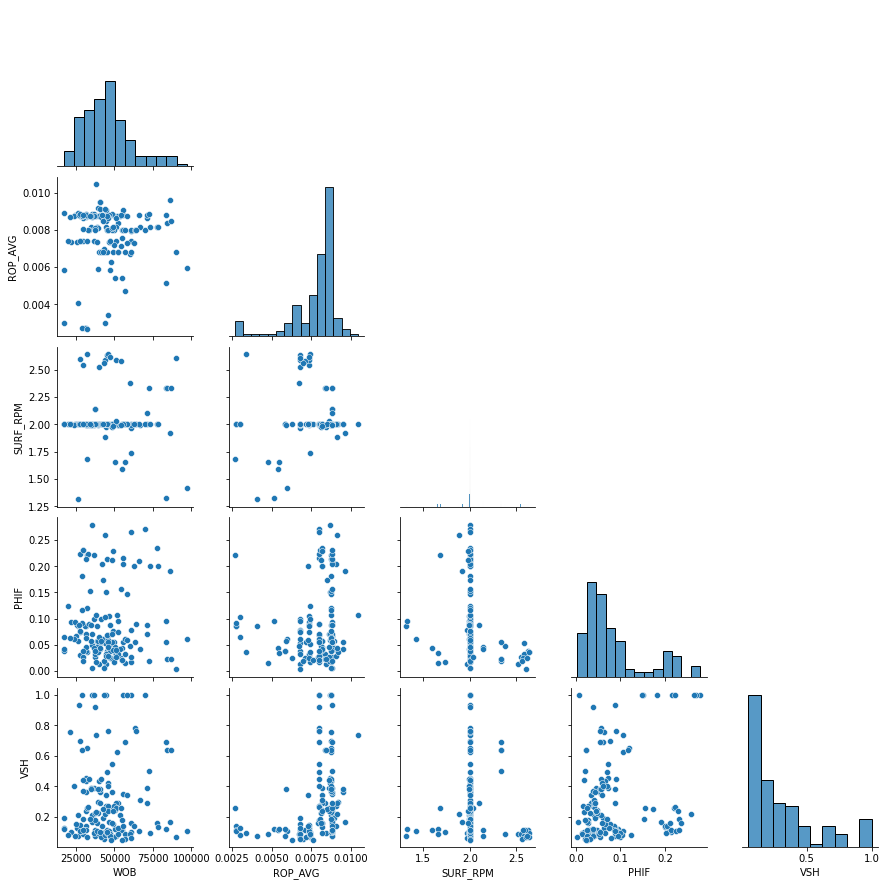

In [7]:
# Create pair plot
sns.pairplot(df[['WOB', 'ROP_AVG', 'SURF_RPM', 'PHIF', 'VSH']], corner=True)

In [8]:
# Separate feature and target
X = df.drop(['ROP_AVG'], axis=1)
y = df['ROP_AVG']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=10)

# Make pipeline
steps = [('scaler', StandardScaler()), 
         ('gbr', GradientBoostingRegressor(min_samples_leaf=6, max_depth=20, 
                                           random_state=10))]
pipe = Pipeline(steps)

# Fit pipeline to training data
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(max_depth=20, min_samples_leaf=6,
                                           random_state=10))])

In [9]:
# Evaluate model with R2 metric
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print(f'R2 on train set: {train_score:.2f}')
print(f'R2 on test set: {test_score:.2f}')

R2 on train set: 0.98
R2 on test set: 0.77


In [10]:
# Create a function for prediction
def predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB, SURF_RPM):
  # Make a test input
  X_test = np.array([Depth, WOB, SURF_RPM, PHIF, VSH, SW, KLOGH])  
  X_test = X_test.reshape(1,-1)

  # Predict on a test input
  y_pred = model.predict(X_test)
  return y_pred[0]

In [11]:
# Ignore user warning
import warnings
warnings.simplefilter('ignore', UserWarning)

# Predict on new inputs
predict(pipe, 4000, 0.2, 0.5, 1, 500, WOB=5e4, SURF_RPM=2) 

0.008385100886684715

In [12]:
# Create a function to plot decision boundaries
def plot_space(model, WOB, SURF_RPM, constant_inputs):
  N_matrix = np.empty((len(WOB), len(SURF_RPM)))
  for i in range(len(WOB)):
    for j in range(len(SURF_RPM)):
      # Unwrap constant variables
      Depth, PHIF, VSH, SW, KLOGH = constant_inputs.values()
      N = predict(model, Depth, PHIF, VSH, SW, KLOGH, WOB=WOB[i], SURF_RPM=SURF_RPM[j])
      N_matrix[i][j] = N  
    
  plt.imshow(N_matrix, origin='lower', aspect='auto', cmap='inferno',
             extent=(min(SURF_RPM), max(SURF_RPM), min(WOB), max(WOB)))  
  plt.xlabel('SURF_RPM')
  plt.ylabel('WOB')
  plt.title('ROP_AVG', pad=10)    
  plt.colorbar()

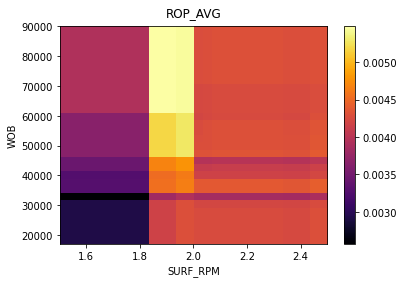

In [13]:
# Range of WOB and RPM values
WOB = np.linspace(17e3, 90e3, 30)
SURF_RPM = np.linspace(1.5, 2.5, 30)

# Constant input variables
constant_inputs = {'Depth': 3480, 'PHIF': 0.09, 'VSH': 0.1, 
                   'SW': 1, 'KLOGH': 0.001}                   

# Plot prediction space
plot_space(pipe, WOB, SURF_RPM, constant_inputs)

In [14]:
# Data at depth 3480 m
df[df.Depth==3480]

,Depth,WOB,SURF_RPM,ROP_AVG,PHIF,VSH,SW,KLOGH
33,3480.0,31236.811,1.999362,0.00271,0.086571,0.139695,1.0,0.001


In [15]:
# Define objective function. "pipe" as model
def f(X):
  return -pipe.predict(X.reshape(1,-1)) # Minus sign to optimize

In [16]:
# Lower bounds of feature variables in the order of X.columns
lb = np.array([3480, 2e4, 1.5, 0.09, 0.1, 1, 0.001])

# Upper bounds of feature variables in the order of X.columns
ub = np.array([3480, 9e4, 2.5, 0.09, 0.1, 1, 0.001])
ub += 1e-10

# Solve optimization
xopt, fopt = pso(f, lb, ub, swarmsize=200, omega=0.3, phip=.5, 
                 phig=0.7, maxiter=1000, minstep=1e-8)

Stopping search: maximum iterations reached --> 1000


In [17]:
# Print values that causes maximum ROP from xopt
for i in range(len(X.columns)):
  print(f'{X.columns[i]}: {xopt[i]:.2f}')

# Print value of maximum ROP from popt
print(f'Maximum ROP achieved: {-fopt}')

Depth: 3480.00
WOB: 61287.99
SURF_RPM: 2.00
PHIF: 0.09
VSH: 0.10
SW: 1.00
KLOGH: 0.00
Maximum ROP achieved: [0.00567214]
